In [1]:
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import hashlib
tqdm.pandas()

# Play with the data

In [2]:
data_csv = '/Users/elad/workspace/playground/stuff/horn_kedar/pivoted_data.csv'
minor_major_csv = '/Users/elad/workspace/playground/stuff/horn_kedar/cleaned74-97_validated_updated.csv'
minor_major_part2_csv = '/Users/elad/workspace/playground/stuff/horn_kedar/machine learning 4-1 validation_EH.csv'
data = pd.read_csv(data_csv)
data.drop(columns=['true_year'], inplace=True)
data.drop_duplicates(['tik_id'], inplace=True)

print(data.shape)

data.head(1)

(28893, 69)


/var/folders/m_/d2zp54zj6z30q0m6pwjffz4m0000gn/T/ipykernel_10755/2718279703.py:4: DtypeWarning: Columns (2,4,28,34,38,39,42,46,56,57,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_csv)


,tik_id,_f1,_f2,_f3,_f4,_f5,_f6,_f7,_f8,_f9,...,_f59,_f60,_f61,_f62,_f63,_f64,_f65,_f66,_f67,_f68
0,10010,NaN,NaN,"[2001, 2001, 1994, 1994, 1981, 1981, 1980, 197...",NaN,NaN,"[2001, 1994, 1994, 1994, 1990, 1981, 1980, 198...",[2006],[2006],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

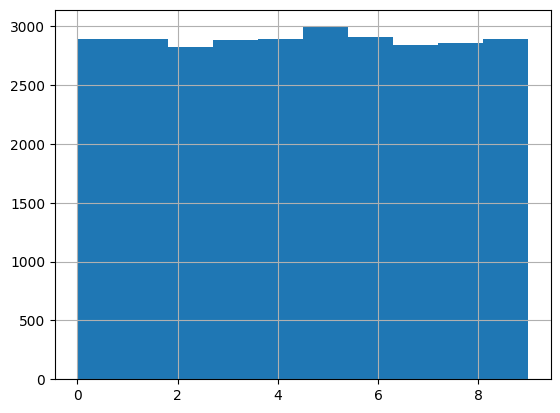

In [108]:
train_percent = 80

def stable_hash(value):
    """Compute a stable hash for the given value."""
    value_str = str(value).encode('utf-8')  # Convert to string and then bytes
    hash_object = hashlib.md5(value_str)  # Use MD5 or other algorithms
    return int(hash_object.hexdigest(), 16)  # Convert hash to an integer

data['fold_id'] = data.tik_id.apply(stable_hash) % 10

data['fold'] = data.fold_id.map(lambda x: 'train' if x < train_percent/10 else 'test')
data.fold_id.hist()

In [109]:
data['min_year'] = data.apply(lambda rec: min([min(eval(v)) for x, v in rec.items() if x.startswith('_f') and isinstance(v, str)]), axis=1)
data['max_year'] = data.apply(lambda rec: max([max(eval(v)) for x, v in rec.items() if x.startswith('_f') and isinstance(v, str)]), axis=1)
data['year_diff'] = data.max_year - data.min_year

data.min_year.min(), data.max_year.max()

(1880, 2021)

In [110]:
FIRST_RELEVANT_YEAR = 1974
LAST_RELEVANT_YEAR = 1997
INTERVAL_YEARS = 5
FIRST_YEAR = FIRST_RELEVANT_YEAR - INTERVAL_YEARS
LAST_YEAR = LAST_RELEVANT_YEAR + INTERVAL_YEARS
NUM_FIELDS = 68
MIN_YEARS_BETWEEN_TWO_EVENTS = 15
FIELDS = data.columns[1:1+NUM_FIELDS]
FIELDS

Index(['_f1', '_f2', '_f3', '_f4', '_f5', '_f6', '_f7', '_f8', '_f9', '_f10',
       '_f11', '_f12', '_f13', '_f14', '_f15', '_f16', '_f17', '_f18', '_f19',
       '_f20', '_f21', '_f22', '_f23', '_f24', '_f25', '_f26', '_f27', '_f28',
       '_f29', '_f30', '_f31', '_f32', '_f33', '_f34', '_f35', '_f36', '_f37',
       '_f38', '_f39', '_f40', '_f41', '_f42', '_f43', '_f44', '_f45', '_f46',
       '_f47', '_f48', '_f49', '_f50', '_f51', '_f52', '_f53', '_f54', '_f55',
       '_f56', '_f57', '_f58', '_f59', '_f60', '_f61', '_f62', '_f63', '_f64',
       '_f65', '_f66', '_f67', '_f68'],
      dtype='object')

In [111]:
def rec_to_vec(rec):
    vec_list = defaultdict(lambda: [0]*NUM_FIELDS)
    for f_idx, field in enumerate(FIELDS):
        if not isinstance(rec[field], str):
            continue
        year_list = eval(rec[field])
        for year in year_list:
            if year < FIRST_YEAR:
                continue
            vec_list[year][f_idx] += 1
    return vec_list


In [112]:
# test
rec = data.iloc[19]
vec = rec_to_vec(rec)

rec.tik_id, rec._f6, vec[1994][5]

(10210,
 '[1994, 1994, 1932, 1932, 1932, 1931, 1931, 1931, 1931, 1931, 1930, 1930]',
 2)

In [113]:
data['vec'] = data.progress_apply(rec_to_vec, axis=1)

  0%|          | 0/28893 [00:00<?, ?it/s]

In [114]:
# Add the labels
minor_major = pd.read_csv(minor_major_csv)

print(minor_major.shape)
print(minor_major.tik_id.nunique())
minor_major.head(1)

(1011, 8)
1009


,tik_id,address,YEAR,Date construction begin - היתר תכנית חתומה - שלם ראשון,MINOR,MAJOR,distance,additional_year
0,10210,"יפו 21, גת רימון 6, גת רימון 4",1995,01/12/1995,0.0,NaN,0,NaN


In [115]:
minor_major[minor_major.duplicated('tik_id', keep=False)]

,tik_id,address,YEAR,Date construction begin - היתר תכנית חתומה - שלם ראשון,MINOR,MAJOR,distance,additional_year
105,690140,ביאליק 20,1979,27/06/1995,NaN,0,0,NaN
185,690140,"החשמונאים 14, חיות פרץ 13, החשמונאים 14 א",1991,30/11/1987,NaN,0,3,NaN
744,10950260,"אהבת ציון 26, 1279 2, אהבת ציון 26 א",1979,11/06/1979,NaN,0,2,NaN
745,10950260,"אהבת ציון 26, 1279 2, אהבת ציון 26 א",1979,11/06/1979,2.0,NaN,2,NaN


In [116]:
np.isnan(minor_major.iloc[1].MAJOR)

True

In [117]:
minor_major['label'] = minor_major.YEAR
minor_major.loc[minor_major.MAJOR.isna(), 'label'] = None
minor_major.drop_duplicates('tik_id', keep='first', inplace=True)

In [118]:
minor_major.head(1)

,tik_id,address,YEAR,Date construction begin - היתר תכנית חתומה - שלם ראשון,MINOR,MAJOR,distance,additional_year,label
0,10210,"יפו 21, גת רימון 6, גת רימון 4",1995,01/12/1995,0.0,NaN,0,NaN,NaN


In [119]:
# verify
minor_major.MAJOR.dropna().count(), minor_major.label.dropna().count()

(433, 433)

In [141]:
minor_major_part2 = pd.read_csv(minor_major_part2_csv)
minor_major_part2['YEAR'] = minor_major_part2.estimated_year
minor_major_part2['other_year'] = minor_major_part2['other year?']
minor_major_part2_filtered = minor_major_part2[(minor_major_part2.Major.notna()) & (minor_major_part2.estimated_year >= FIRST_RELEVANT_YEAR) & (minor_major_part2.estimated_year <= LAST_RELEVANT_YEAR)]
print(minor_major_part2_filtered.shape, minor_major_part2_filtered.tik_id.nunique())
minor_major_part2_filtered.head()

(108, 11) 97


,tik_id,estimated_year,probability,status,real status,Minor,Major,other year?,comments,YEAR,other_year
0,10210,1995,NaN,NaN,NaN,1.0,0.0,0,NaN,1995,0
2,10620,1993,NaN,NaN,NaN,1.0,0.0,0,NaN,1993,0
3,20030,1977,NaN,NaN,NaN,1.0,0.0,0,NaN,1977,0
4,20150,1974,0.999992,known,known,0.0,1.0,NaN,NaN,1974,NaN
5,30200,1995,1.000000,mismatch,NaN,1.0,0.0,NaN,NaN,1995,NaN


In [121]:
repeated_tikid = minor_major_part2_filtered[minor_major_part2_filtered.duplicated('tik_id', keep=False)]
repeated_tikid

,tik_id,estimated_year,probability,status,real status,Minor,Major,other year?,comments,YEAR
5,30200,1995,1.000000,mismatch,NaN,1.0,0.0,NaN,NaN,1995
6,30200,1981,1.000000,new,NaN,0.0,1.0,NaN,NaN,1981
8,40010,1990,1.000000,new,NaN,1.0,0.0,1993,no reason to find more then one,1990
9,40010,1993,1.000000,new,NaN,0.0,1.0,NaN,NaN,1993
37,80230,1988,1.000000,mismatch,NaN,1.0,0.0,0,NaN,1988
38,80230,1978,0.686097,new,NaN,1.0,0.0,0,NaN,1978
134,690140,1987,0.999998,known,NaN,0.0,1.0,0,NaN,1987
135,690140,1990,1.000000,new,NaN,0.0,1.0,1991,NaN,1990
361,5230240,1978,1.000000,known,NaN,1.0,0.0,1976,NaN,1978
363,5230240,1976,1.000000,new,NaN,0.0,1.0,0,NaN,1976


In [122]:
part2_only = minor_major_part2_filtered.merge(minor_major, on=['tik_id', 'YEAR'], how='left', suffixes=('_part2', '_part1'))
part2_only = part2_only[part2_only.address.isna()]
print(part2_only.shape, part2_only.tik_id.nunique())
part2_only


(19, 17) 16


,tik_id,estimated_year,probability,status,real status,Minor,Major,other year?,comments,YEAR,address,Date construction begin - היתר תכנית חתומה - שלם ראשון,MINOR,MAJOR,distance,additional_year,label
4,30200,1995,1.000000,mismatch,NaN,1.0,0.0,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,40010,1990,1.000000,new,NaN,1.0,0.0,1993,no reason to find more then one,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,40010,1993,1.000000,new,NaN,0.0,1.0,NaN,NaN,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,80230,1978,0.686097,new,NaN,1.0,0.0,0,NaN,1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,230200,1979,1.000000,new,NaN,0.0,1.0,0,NaN,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,690140,1987,0.999998,known,NaN,0.0,1.0,0,NaN,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,690140,1990,1.000000,new,NaN,0.0,1.0,1991,NaN,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,960140,1994,1.000000,new,NaN,0.0,1.0,1993,NaN,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,5230240,1976,1.000000,new,NaN,0.0,1.0,0,NaN,1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,6000080,1996,1.000000,new,NaN,1.0,0.0,0,NaN,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
duplicates = minor_major_part2_filtered.merge(minor_major, on=['tik_id', 'YEAR'], how='inner')
duplicates_filtered = duplicates[((duplicates.Minor == 1) & (duplicates.MINOR.isna())) | ((duplicates.Major == 1) & (duplicates.MAJOR.isna()))]
print(duplicates_filtered.shape)
duplicates_filtered[['tik_id', 'YEAR', 'Minor', 'MINOR', 'Major', 'MAJOR']]

(4, 17)


,tik_id,YEAR,Minor,MINOR,Major,MAJOR
5,31550,1995,1.0,NaN,0.0,1
16,60600,1992,0.0,3.0,1.0,NaN
67,8990160,1991,0.0,0.0,1.0,NaN
70,10940130,1986,0.0,0.0,1.0,NaN


(1009, 83)


<Axes: >

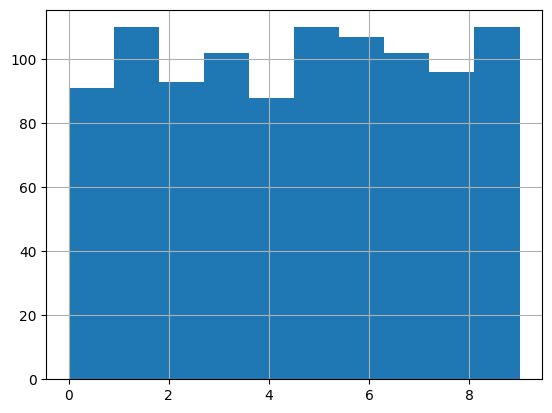

In [124]:
labeled_data = data.merge(minor_major, on='tik_id', how='inner')
print(labeled_data.shape)

labeled_data.fold_id.hist()

In [153]:
labeled_data['know_all_years'] = False
known_years = minor_major_part2_filtered[minor_major_part2_filtered.other_year.notna()].tik_id
labeled_data.loc[labeled_data.tik_id.isin(known_years), 'know_all_years'] = True
labeled_data.head()

,tik_id,_f1,_f2,_f3,_f4,_f5,_f6,_f7,_f8,_f9,...,address,YEAR,Date construction begin - היתר תכנית חתומה - שלם ראשון,MINOR,MAJOR,distance,additional_year,label,know_all_years,other_year
0,10210,NaN,NaN,"[1994, 1993, 1950]",NaN,NaN,"[1994, 1994, 1932, 1932, 1932, 1931, 1931, 193...",[1994],[2019],NaN,...,"יפו 21, גת רימון 6, גת רימון 4",1995,01/12/1995,0.0,NaN,0,NaN,NaN,True,0
1,10620,NaN,NaN,"[2010, 1993, 1993, 1992, 1992, 1992, 1936, 193...",NaN,NaN,"[1993, 1993, 1992, 1992, 1962, 1962, 1933, 193...",NaN,NaN,NaN,...,"יפו 62, העליה 2",1993,22/08/1993,3.0,NaN,0,NaN,NaN,True,0
2,20030,NaN,NaN,[1954],NaN,NaN,"[1977, 1977]",NaN,NaN,NaN,...,הרצל 3,1977,29/05/1977,2.0,NaN,-,NaN,NaN,True,0
3,20150,NaN,NaN,"[1996, 1977, 1971, 1968, 1947, 1940, 1940, 193...",NaN,NaN,"[1986, 1977, 1977, 1974, 1973, 1973, 1971, 196...",NaN,NaN,NaN,...,הרצל 15,1974,19/09/1974,NaN,0,-,NaN,1974.0,False,NaN
4,30160,NaN,NaN,"[1990, 1989, 1989, 1989, 1989, 1969, 1957, 195...",NaN,NaN,"[1992, 1991, 1991, 1990, 1989, 1989, 1975, 197...",NaN,NaN,NaN,...,"נחלת בנימין 16, רמב""ם 11",1989,12/06/1989,2.0,NaN,0,NaN,NaN,False,NaN


# Trying Time Series Model (RNN)

In [128]:
USE_MASK = True  # If set to True, uses mask for the missing labels
USE_TWO_CLASSES = False  # If set to False, uses sigmoid with BCEWithLogitsLoss, if True uses BCELoss
if USE_MASK:
    USE_TWO_CLASSES = False

In [154]:
def get_dataset(rec):
    vec = rec.vec
    max_years = LAST_YEAR - FIRST_YEAR
    X = torch.tensor([vec[FIRST_YEAR + year] for year in range(max_years+1)], dtype=torch.float32)
    if USE_TWO_CLASSES:
        y = torch.zeros(max_years+1, 2, dtype=torch.float32)
        y[:, 0] = 1
        if rec.label is not None and not np.isnan(rec.label):
            y[int(rec.label - FIRST_YEAR), 0] = 0
            y[int(rec.label - FIRST_YEAR), 1] = 1
    else:
        y = torch.zeros(max_years+1, dtype=torch.float32)
        if rec.label is not None and not np.isnan(rec.label):
            y[int(rec.label - FIRST_YEAR)] = 1
    return X, y

def get_dataset_x_only(rec):
    vec = rec.vec
    max_years = LAST_YEAR - FIRST_YEAR
    X = torch.tensor([vec[FIRST_YEAR + year] for year in range(max_years+1)], dtype=torch.float32)
    return X

def get_dataset_as_classes(rec):
    vec = rec.vec
    max_years = LAST_YEAR - FIRST_YEAR
    X = torch.tensor([vec[year + FIRST_YEAR] for year in range(max_years+1)], dtype=torch.float32)
    y = torch.tensor([1.0, 0.0])
    if rec.label is not None and not np.isnan(rec.label):
        y = torch.tensor([0.0, 1.0])
    return X, y

def get_dataset_with_mask(rec):
    vec = rec.vec
    max_years = LAST_YEAR - FIRST_YEAR
    X = torch.tensor([vec[FIRST_YEAR + year] for year in range(max_years+1)], dtype=torch.float32)
    y = torch.zeros(max_years+1, dtype=torch.float32)
    mask = torch.zeros(max_years+1, dtype=torch.float32)
    if rec.label is not None and not np.isnan(rec.label):
        y[int(rec.label - FIRST_YEAR)] = 1
        other_years = rec.additional_year
        if other_years >= FIRST_RELEVANT_YEAR:
            y[int(other_years - FIRST_YEAR)] = 1
        mask[INTERVAL_YEARS : -INTERVAL_YEARS] = 1
    elif rec.know_all_years:
        mask[INTERVAL_YEARS : -INTERVAL_YEARS] = 1
    else:
        mask[INTERVAL_YEARS : int(rec.YEAR - FIRST_YEAR) + 1] = 1
    return X, y, mask

In [155]:
# example
if USE_MASK:
    X, y, mask = get_dataset_with_mask(labeled_data.iloc[0])
else:
    X, y = get_dataset(labeled_data.iloc[0])
labeled_data.iloc[0].tik_id, X.shape, y.shape, sum(y), X[1994-FIRST_YEAR, :6]

(10210,
 torch.Size([34, 68]),
 torch.Size([34]),
 tensor(0.),
 tensor([0., 0., 1., 0., 0., 2.]))

In [180]:
# another example
rec = labeled_data[labeled_data.tik_id == 120160]
if USE_MASK:
    X, y, mask = get_dataset_with_mask(rec.iloc[0])
else:
    X, y = get_dataset(rec.iloc[0])
rec[['tik_id', 'YEAR', 'additional_year', 'know_all_years']], y


(    tik_id  YEAR  additional_year  know_all_years
 78  120160  1991           1975.0            True,
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [156]:
class BinaryClassificationRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, bidirectional: bool):
        super(BinaryClassificationRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=bidirectional, nonlinearity='relu')
        if not USE_TWO_CLASSES:
            self.fc = nn.Linear(hidden_size * (int(bidirectional)+1), 1)
            self.final = nn.Sigmoid()
        else:
            self.fc = nn.Linear(hidden_size * (int(bidirectional)+1), 2)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        if not USE_TWO_CLASSES:
            out = self.final(out)
            out.squeeze(-1)
        return out

In [157]:
class BCEWithLogitsLossWithMask(nn.BCEWithLogitsLoss):
    def __init__(self, pos_weight=None):
        super(BCEWithLogitsLossWithMask, self).__init__(reduction='none', pos_weight=pos_weight)
        self.pos_weight = pos_weight if pos_weight is not None else 1.0

    def forward(self, y_pred, y, mask):
        y_prob = 1 / (1 + torch.exp(-y_pred))
        loss = -(self.pos_weight * y * torch.log(y_prob + 1e-8) + (1 - y) * torch.log(1 - y_prob + 1e-8))
        masked_loss = loss * mask
        if mask.sum() == 0:
            return masked_loss.sum()
        return masked_loss.sum() / mask.sum()

In [191]:
input_size = NUM_FIELDS
hidden_size = 5
bidirectional = True
num_epochs = 10001
pos_weight = torch.tensor([100.0])

model = BinaryClassificationRNN(input_size, hidden_size, bidirectional)
if USE_TWO_CLASSES:
    criterion = nn.CrossEntropyLoss()
elif USE_MASK:
    criterion = BCEWithLogitsLossWithMask(pos_weight=pos_weight)
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler_onecycle = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    total_steps=2000,
    pct_start=0.3,
    cycle_momentum=False
)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=2000,  # Maximum number of iterations
    eta_min=0.0001  # Minimum learning rate
)

scheduler_exponential = optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.95  # Decay factor for the rest of the training steps
)

# Combine schedulers using ChainedScheduler
scheduler = optim.lr_scheduler.ChainedScheduler([scheduler_onecycle, scheduler_cosine, scheduler_exponential])


In [182]:
train_data = labeled_data[labeled_data.fold == 'train']
test_data = labeled_data[labeled_data.fold == 'test']

train_data.shape, test_data.shape

((803, 85), (206, 85))

In [183]:
if USE_MASK:
    dataset_train = [get_dataset_with_mask(rec) for rec in tqdm(train_data.itertuples())]
    dataset_test = [get_dataset_with_mask(rec) for rec in tqdm(test_data.itertuples())]
else:
    dataset_train = [get_dataset(rec) for rec in tqdm(train_data.itertuples())]
    dataset_test = [get_dataset(rec) for rec in tqdm(test_data.itertuples())]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [184]:
# verify
sum(y.sum() for _, y, _ in dataset_train), labeled_data[(labeled_data.fold == 'train') & labeled_data.MAJOR.notna()].shape[0]

(tensor(349.), 346)

In [185]:
def infer(model, X):
    with torch.no_grad():
        predictions = model(X.unsqueeze(0))
        if USE_TWO_CLASSES:
            predictions_01 = predictions.argmax(dim=2)
            predictions_prob = predictions.softmax(dim=2)
        else:
            predictions_01 = predictions.round().squeeze()
            predictions_prob = predictions.squeeze()

    predictions_01[:FIRST_RELEVANT_YEAR - FIRST_YEAR] = 0
    predictions_01[LAST_RELEVANT_YEAR - FIRST_YEAR + 1:] = 0
    pred_idx = (predictions_01 == 1).nonzero(as_tuple=True)[0]
    curr_idx = pred_idx[0] if len(pred_idx) > 0 else None
    for idx in pred_idx[1:]:
        if idx - curr_idx < MIN_YEARS_BETWEEN_TWO_EVENTS:
            if predictions_prob[idx] > predictions_prob[curr_idx]:
                predictions_01[curr_idx] = 0
                curr_idx = idx
            else:
                predictions_01[idx] = 0
        else:
            curr_idx = idx
    return predictions_01, predictions_prob

def evaluate_with_interval(reference_y, compared_y, interval_years):
    # get all the indices where y_test is 1
    trues = 0
    falses = 0
    pred_idx = (reference_y == 1).nonzero(as_tuple=True)[0]
    for idx in pred_idx:
        if torch.max(compared_y[max(0, idx-interval_years):idx+interval_years+1]) == 1:
            trues += 1
        else:
            falses += 1
    return trues, falses

def evaluate(model, dataset_test):
    # Predict
    total_accuracy = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    prec_FP_pm2 = 0
    prec_TP_pm2 = 0
    prec_FP_pm3 = 0
    prec_TP_pm3 = 0
    reca_TP_pm2 = 0
    reca_FN_pm2 = 0
    reca_TP_pm3 = 0
    reca_FN_pm3 = 0

    model.eval()
    for sample in dataset_test:
        if USE_MASK:
            X_test, y_test, _ = sample
        else:
            X_test, y_test = sample
        predictions_01 = infer(model, X_test)[0]
        total_accuracy += (predictions_01 == y_test).float().mean()
        TP += (predictions_01 * y_test).sum()
        TN += ((1 - predictions_01) * (1 - y_test)).sum()
        FP += (predictions_01 * (1 - y_test)).sum()
        FN += ((1 - predictions_01) * y_test).sum()
        ts, fs = evaluate_with_interval(predictions_01, y_test, 2)
        prec_TP_pm2, prec_FP_pm2 = prec_TP_pm2 + ts, prec_FP_pm2 + fs
        ts, fs = evaluate_with_interval(predictions_01, y_test, 3)
        prec_TP_pm3, prec_FP_pm3 = prec_TP_pm3 + ts, prec_FP_pm3 + fs
        ts, fs = evaluate_with_interval(y_test, predictions_01, 2)
        reca_TP_pm2, reca_FN_pm2 = reca_TP_pm2 + ts, reca_FN_pm2 + fs
        ts, fs = evaluate_with_interval(y_test, predictions_01, 3)
        reca_TP_pm3, reca_FN_pm3 = reca_TP_pm3 + ts, reca_FN_pm3 + fs
            
    total_accuracy /= len(dataset_test)
    total_recall = TP / (TP + FN)
    total_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    total_recall_pm2 = reca_TP_pm2 / (reca_TP_pm2 + reca_FN_pm2) 
    total_recall_pm3 = reca_TP_pm3 / (reca_TP_pm3 + reca_FN_pm3)
    total_precision_pm2 = prec_TP_pm2 / (prec_TP_pm2 + prec_FP_pm2) if (prec_TP_pm2 + prec_FP_pm2) > 0 else 0
    total_precision_pm3 = prec_TP_pm3 / (prec_TP_pm3 + prec_FP_pm3) if (prec_TP_pm3 + prec_FP_pm3) > 0 else 0
    

    return {
        'accuracy': total_accuracy,
        'recall': total_recall,
        'precision': total_precision,
        'recall_pm2': total_recall_pm2,
        'precision_pm2': total_precision_pm2,
        'recall_pm3': total_recall_pm3,
        'precision_pm3': total_precision_pm3,
    }

In [186]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()} parameters, shape: {param.shape}")

# Call the function
count_parameters(model)


Total parameters: 761
rnn.weight_ih_l0: 340 parameters, shape: torch.Size([5, 68])
rnn.weight_hh_l0: 25 parameters, shape: torch.Size([5, 5])
rnn.bias_ih_l0: 5 parameters, shape: torch.Size([5])
rnn.bias_hh_l0: 5 parameters, shape: torch.Size([5])
rnn.weight_ih_l0_reverse: 340 parameters, shape: torch.Size([5, 68])
rnn.weight_hh_l0_reverse: 25 parameters, shape: torch.Size([5, 5])
rnn.bias_ih_l0_reverse: 5 parameters, shape: torch.Size([5])
rnn.bias_hh_l0_reverse: 5 parameters, shape: torch.Size([5])
fc.weight: 10 parameters, shape: torch.Size([1, 10])
fc.bias: 1 parameters, shape: torch.Size([1])


In [192]:
# Using two classes
batch_size = 32  # Define batch size
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

losses = {
    'loss': [],
    'train': [],
    'test': [],
}
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_losses = []
    for sample in dataloader:
        if USE_MASK:
            X_batch, y_batch, mask = sample
        else:
            X_batch, y_batch = sample
        optimizer.zero_grad()
        outputs = model(X_batch)
        if USE_MASK:
            loss = criterion(outputs.squeeze(), y_batch, mask)
        else:
            loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    losses['loss'].append(sum(epoch_losses) / len(epoch_losses))
    if (epoch + 1) % 100 == 0:
        scheduler.step()
        ev_train = evaluate(model, dataset_train)
        ev_test = evaluate(model, dataset_test)
        ev_train_text = ', '.join([f'{k}: {v:.4f}' for k, v in ev_train.items()])
        ev_test_text = ', '.join([f'{k}: {v:.4f}' for k, v in ev_test.items()])
        losses['train'].append(ev_train)
        losses['test'].append(ev_test)
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses['loss'][-1]:.4f}, Train: {ev_train_text}, Test: {ev_test_text}")


  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch [100/10001], Loss: 1.4943, Train: accuracy: 0.9756, recall: 0.7020, precision: 0.3040, recall_pm2: 0.9112, precision_pm2: 0.3945, recall_pm3: 0.9341, precision_pm3: 0.4045, Test: accuracy: 0.9744, recall: 0.6782, precision: 0.2810, recall_pm2: 0.8966, precision_pm2: 0.3714, recall_pm3: 0.9425, precision_pm3: 0.3905
Epoch [200/10001], Loss: 1.4335, Train: accuracy: 0.9794, recall: 0.8166, precision: 0.3645, recall_pm2: 0.9198, precision_pm2: 0.4105, recall_pm3: 0.9427, precision_pm3: 0.4207, Test: accuracy: 0.9754, recall: 0.7126, precision: 0.2967, recall_pm2: 0.8966, precision_pm2: 0.3732, recall_pm3: 0.9195, precision_pm3: 0.3828
Epoch [300/10001], Loss: 1.4427, Train: accuracy: 0.9811, recall: 0.8281, precision: 0.3884, recall_pm2: 0.9255, precision_pm2: 0.4341, recall_pm3: 0.9427, precision_pm3: 0.4422, Test: accuracy: 0.9772, recall: 0.7241, precision: 0.3166, recall_pm2: 0.8506, precision_pm2: 0.3719, recall_pm3: 0.8736, precision_pm3: 0.3819
Epoch [400/10001], Loss: 1.3980

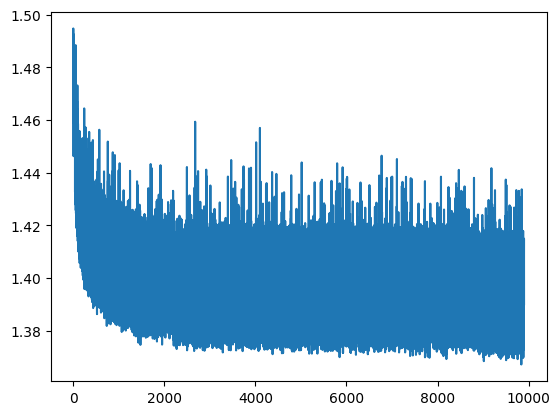

{'accuracy': tensor(0.9864),
 'recall': tensor(0.7241),
 'precision': tensor(0.4701),
 'recall_pm2': 0.7931034482758621,
 'precision_pm2': 0.5149253731343284,
 'recall_pm3': 0.8275862068965517,
 'precision_pm3': 0.5373134328358209}

In [194]:
plt.plot(losses['loss'][100:])
plt.show()
evaluate(model, dataset_test)

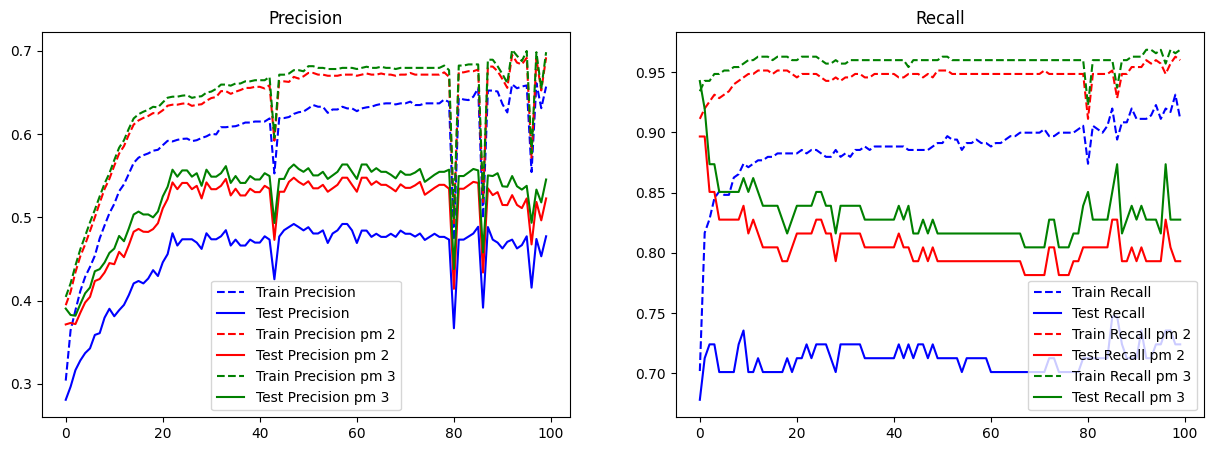

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot([x['precision'] for x in losses['train']], label='Train Precision', color='blue', linestyle='dashed')
ax[0].plot([x['precision'] for x in losses['test']], label='Test Precision', color='blue', linestyle='solid')
ax[0].plot([x['precision_pm2'] for x in losses['train']], label='Train Precision pm 2', color='red', linestyle='dashed')
ax[0].plot([x['precision_pm2'] for x in losses['test']], label='Test Precision pm 2', color='red', linestyle='solid')
ax[0].plot([x['precision_pm3'] for x in losses['train']], label='Train Precision pm 3', color='green', linestyle='dashed')
ax[0].plot([x['precision_pm3'] for x in losses['test']], label='Test Precision pm 3', color='green', linestyle='solid')
ax[0].set_title('Precision')
ax[0].legend()

ax[1].plot([x['recall'] for x in losses['train']], label='Train Recall', color='blue', linestyle='dashed')
ax[1].plot([x['recall'] for x in losses['test']], label='Test Recall', color='blue', linestyle='solid')
ax[1].plot([x['recall_pm2'] for x in losses['train']], label='Train Recall pm 2', color='red', linestyle='dashed')
ax[1].plot([x['recall_pm2'] for x in losses['test']], label='Test Recall pm 2', color='red', linestyle='solid')
ax[1].plot([x['recall_pm3'] for x in losses['train']], label='Train Recall pm 3', color='green', linestyle='dashed')
ax[1].plot([x['recall_pm3'] for x in losses['test']], label='Test Recall pm 3', color='green', linestyle='solid')
ax[1].set_title('Recall')
ax[1].legend()

plt.show()

In [195]:
evaluate(model, dataset_test)

{'accuracy': tensor(0.9864),
 'recall': tensor(0.7241),
 'precision': tensor(0.4701),
 'recall_pm2': 0.7931034482758621,
 'precision_pm2': 0.5149253731343284,
 'recall_pm3': 0.8275862068965517,
 'precision_pm3': 0.5373134328358209}

### Get all Major Estimations

In [73]:
ds = []
model.eval()
for _, rec in tqdm(data.iterrows(), total=len(data)):
    X = get_dataset_x_only(rec)
    predictions_01, predictions_prob = infer(model, X)
    pred_idx = (predictions_01 == 1).nonzero(as_tuple=True)[0]
    for idx in pred_idx:
        estimated_year = idx.detach().item() + FIRST_YEAR
        status = 'new'
        combine_with_dataset = labeled_data[labeled_data.tik_id == rec.tik_id]
        if len(combine_with_dataset) >= 1 and combine_with_dataset.iloc[0].YEAR == estimated_year:
            curr = combine_with_dataset.iloc[0]
            status = 'known' if curr.label is not None and not np.isnan(curr.label) else 'mismatch'
        ds.append({
            'tik_id': rec.tik_id,
            'estimated_year': estimated_year,
            'probability': predictions_prob[idx].item(),
            'status': status,
        })
    
predictions_df = pd.DataFrame(ds)
predictions_df.head()

  0%|          | 0/28893 [00:00<?, ?it/s]

,tik_id,estimated_year,probability,status
0,10010,1994,1.000000,new
1,10030,1975,0.998315,new
2,10170,1978,1.000000,new
3,10260,1987,1.000000,new
4,10360,1995,1.000000,new


In [74]:
predictions_df.status.value_counts()

status
new         5900
known        365
mismatch     114
Name: count, dtype: int64

In [75]:
tikid_count = predictions_df.tik_id.value_counts()
print(tikid_count[tikid_count > 1].shape, tikid_count[tikid_count > 1].sum(), predictions_df.tik_id.nunique())
tikid_count[tikid_count > 1]

(107,) 214 6272


tik_id
8250050     2
30012070    2
30040360    2
9810130     2
36610040    2
           ..
20060060    2
8310200     2
9141360     2
450160      2
9850271     2
Name: count, Length: 107, dtype: int64

In [78]:
prediction_csv = '/Users/elad/workspace/playground/stuff/horn_kedar/prediction_time_series_with_masking.csv'
predictions_df.to_csv(prediction_csv, index=False)
predictions_df.shape

(6379, 4)

# Trying "Has Major" Model (CNN)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
INPUT_SIZE = (LAST_YEAR - FIRST_YEAR + 1, NUM_FIELDS)

OUT_CHANNELS_LAYER_1 = 4
OUT_CHANNELS_LAYER_2 = 8
OUT_CHANNELS_LAYER_3 = 16
KERNEL_WIDTH_LAYER_1 = 11
KERNEL_WIDTH_LAYER_2 = 5
KERNEL_WIDTH_LAYER_3 = 3
MAX_POOLING_KERNEL_SIZE = 3
MAX_POOLING_KERNEL_STRIDE = 2
LINEAR_LAYER_1 = 512
LINEAR_LAYER_2 = 64

class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallAlexNet, self).__init__()
        self.features = nn.Sequential(
            # Layer 1: Convolutional + ReLU + MaxPooling
            nn.Conv2d(in_channels=1, out_channels=OUT_CHANNELS_LAYER_1, kernel_size=(KERNEL_WIDTH_LAYER_1, 1), stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(MAX_POOLING_KERNEL_SIZE, 1), stride=(MAX_POOLING_KERNEL_STRIDE, 1)),
            # OUTPUT_WIDTH = (INPUT_WIDTH - KERNEL_SIZE + 2*PADDING) / STRIDE + 1
            
            # Layer 2: Convolutional + ReLU + MaxPooling
            nn.Conv2d(OUT_CHANNELS_LAYER_1, OUT_CHANNELS_LAYER_2, kernel_size=(KERNEL_WIDTH_LAYER_2, 1), stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(MAX_POOLING_KERNEL_SIZE, 1), stride=(MAX_POOLING_KERNEL_STRIDE, 1)),
            
            # Layer 3: Convolutional + ReLU + MaxPooling
            nn.Conv2d(OUT_CHANNELS_LAYER_2, OUT_CHANNELS_LAYER_3, kernel_size=(KERNEL_WIDTH_LAYER_3, 1), stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(MAX_POOLING_KERNEL_SIZE, 1), stride=(MAX_POOLING_KERNEL_STRIDE, 1)),
        )
        
        output_width_1 = (LAST_YEAR - FIRST_YEAR + 1 - KERNEL_WIDTH_LAYER_1) // MAX_POOLING_KERNEL_STRIDE
        output_width_2 = (output_width_1 - KERNEL_WIDTH_LAYER_2) // MAX_POOLING_KERNEL_STRIDE
        output_width_3 = (output_width_2 - KERNEL_WIDTH_LAYER_3) // MAX_POOLING_KERNEL_STRIDE
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(OUT_CHANNELS_LAYER_3 * output_width_3 * NUM_FIELDS, LINEAR_LAYER_1),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(LINEAR_LAYER_1, LINEAR_LAYER_2),
            nn.ReLU(inplace=True),
            
            nn.Linear(LINEAR_LAYER_2, num_classes),  # Fully connected layer (Output layer)
        )

    def forward(self, x):
        x = x.unsqueeze(1)                # Add a channel dimension
        x = self.features(x)              # Pass through convolutional layers
        x = torch.flatten(x, 1)           # Flatten the output
        x = self.classifier(x)            # Pass through fully connected layers
        return x

In [50]:
# Instantiate the model
model = SmallAlexNet()

# Print the model architecture
print(model)


SmallAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(11, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(5, 1), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(3, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(3, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=(3, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1088, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
dataset_train = [get_dataset_as_classes(rec) for rec in tqdm(train_data.itertuples())]
dataset_test = [get_dataset_as_classes(rec) for rec in tqdm(test_data.itertuples())]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [55]:
batch_size = 32  # Define batch size
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_losses = []
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    losses.append(sum(epoch_losses) / len(epoch_losses))
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            predictions = [model(X_test.unsqueeze(0)).argmax() == y_test.argmax() for X_test, y_test in dataset_test]
            accuracy = sum(predictions) / len(predictions)
        tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]:.4f}, Test Accuracy: {accuracy:.4f}')


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Loss: 0.6824, Test Accuracy: 0.5882
Epoch [101/1000], Loss: 0.4430, Test Accuracy: 0.8088
Epoch [201/1000], Loss: 0.3627, Test Accuracy: 0.7990
Epoch [301/1000], Loss: 0.3331, Test Accuracy: 0.8088
Epoch [401/1000], Loss: 0.3058, Test Accuracy: 0.8039
Epoch [501/1000], Loss: 0.2800, Test Accuracy: 0.8137
Epoch [601/1000], Loss: 0.2288, Test Accuracy: 0.8186
Epoch [701/1000], Loss: 0.1854, Test Accuracy: 0.8333
Epoch [801/1000], Loss: 0.1629, Test Accuracy: 0.8039
Epoch [901/1000], Loss: 0.1423, Test Accuracy: 0.8333


In [123]:
labeled_data[['tik_id', 'fold', 'vec', 'YEAR', 'MINOR', 'MAJOR', 'label']].head(4)

,tik_id,fold,vec,YEAR,MINOR,MAJOR,label
0,10210,train,"{1994: [0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0,...",1995,0.0,NaN,NaN
1,10620,test,"{2010: [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1993,3.0,NaN,NaN
2,20030,train,"{1977: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,...",1977,2.0,NaN,NaN
3,20150,train,"{1996: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",1974,NaN,0,1974.0


In [128]:
ind = 5
[(k, v[ind]) for k,v in train_data.iloc[0].vec.items() if v[ind] > 0]

[(1994, 2)]